## DATA 620 - Final Project (Goodreads Book Recommender System)
##### By: Zach Alexander
##### Date: July 12th, 2020

***

For my final project, I decided to build a book recommendation system. Since I really enjoy reading books, and there were myriad book datasets available, I thought it would be a good opportunity to utilize some of the skills I learned in this course to attempt a build of a modest, full-production book recommender. My final project can be outlined in the following steps:  

+ **Part 1)** I decided to use the `goodbooks-10k` dataset, [located here on Kaggle](https://www.kaggle.com/zygmunt/goodbooks-10k), as my user-item dataset. This dataset has helped to formulate initial recommendations to users, and over time, will include additional books and ratings as more people use the application. Therefore, I initially downloaded the data and performed some exploratory analysis to get a better sense of its components.  

+ **Part 2)** Next, I built out a full production Flask app in python. This included:
  + A full user registration/sign-in function
  + Integration with the Goodreads API to build in a search function which allowed a user to search and rate new books
  + Connecting the Flask application to a PostgreSQL backend database to store user information, their book ratings, and eventually, user-specific book recommendations  
  + Deployed the Flask application on Heroku at this link provided: [https://zach-book-recommender.herokuapp.com/](https://zach-book-recommender.herokuapp.com/)  
  
+ **Part 3)** Then, using the existing `goodbooks-10k` dataset, in combination with a few initial users from my Flask app, I built a recommender system using Pyspark's collaborative filtering and an Alternating Least Squares algorithm to find similarities between users. I did my best to implement some distributive computing in order to cut down on the amount of processing time, which you'll see throughout.
  + This recommendation system model was developed and fine-tuned until reaching an optimal RMSE value (utilizing this jupyter notebook). Then, with the best model I could generate, I used Databricks and AWS to deploy just the optimal model parameters, located in a separate Databricks file to serve as my production model.  
  + By creating a new cron job in Databricks, the deployed model will absorb new user ratings every hour, re-run the model, and recompute new recommendations for each user based on the updated calculations/predictions.  
  
In this notebook below, I've outlined many of the steps above in greater detail. Additionally, I've created a [YouTube video here to explain the process a bit further](https://www.youtube.com/watch?v=Z5JhqceWrzc&feature=youtu.be).

### Part 1) Exploring the goodbooks-10k dataset

As mentioned above, before creating a recommender system, it's always a good idea to familiarize yourself with the dataset. Below are a few initial findings from the `goodbooks-10k` dataset.

##### Dataset Information (goodbooks-10k)

According to Kaggle, the `goodbooks-10k` dataset contains close to 1 million ratings across 10,000 different books located on a popular book recommender service, *Goodreads*. Additionally, in this dataset, there are about 53,425 users that have supplied ratings for at least 10 books. The book ratings are on a likert scale between 1 and 5. 

For the project, I decided to use Alternating Least Squares to provide predictions for books that haven't been read by each user. As mentioned above, although this is a robust dataset, I also thought it would be interesting to incorporate additional book ratings from users that utilize the Flask app that I created **(see Part 2)**. Therefore, although our initial goodbooks-10k dataset will contain close to 1 million ratings, I will also be appending additional user ratings to this dataset to serve recommendations to new users.

##### Loading in the ratings.csv file to explore ratings

The Kaggle dataset contains a few different files, some of which we will use for this project, and others we can hope to utilize in later iterations of the recommendation model. For now, we'll start by loading in the `ratings.csv` file and performing some initial analysis. As we can see from the output below, the table consists of a `book_id`, `user_id` and `rating` column, to show the user-specific rating for a particular book. The `book_id` is specific to this dataset, but fortunately other tables have a crosswalk between the `book_id` and a goodreads-specific book ID, which we can use later on when loading these into the application.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

ratings_df_init = pd.read_csv('./data/ratings.csv')

ratings_df_init.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


##### Overall counts

After loading the `ratings.csv` dataset as a Pandas dataframe, I decided to confirm the count of ratings, users, and books. You can find this in a table below:

In [4]:
num_ratings = ratings_df_init['rating'].count()
num_users = ratings_df_init['user_id'].nunique()
num_books = ratings_df_init['book_id'].nunique()

pd.DataFrame([['# of Ratings', num_ratings],
             ['# of Users', num_users], 
             ['# of Books', num_books]],
            columns = ['Characteristic', 'Count'])

,Characteristic,Count
0,# of Ratings,981756
1,# of Users,53424
2,# of Books,10000


As we can see, there were **981,756** book ratings (~1 million), **53,424** unique users, and **10,000** unique books in our `ratings.csv` dataset.  

##### Average ratings by users

Next, we can take a look at the average rating given by users for all books in our dataset. We can see it displayed here using the `describe()` function, but also plotted in a histogram below:

In [5]:
ratings_df_init['rating'].describe()

count    981756.000000
mean          3.856534
std           0.983941
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

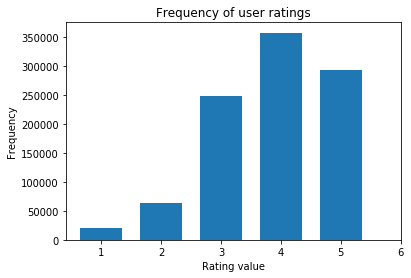

In [6]:
data = ratings_df_init['rating']
bins = [1, 2, 3, 4, 5, 6]

plt.hist(data, bins, align="left", rwidth=0.7)
plt.xticks(bins)
plt.xlabel('Rating value')
plt.ylabel('Frequency')
plt.title('Frequency of user ratings')
plt.show()

As we can see, most users provided pretty positive ratings on books, with the most frequent rating being a 4, and the average being slightly less at ~3.85.  

##### Sparsity of the ratings dataset

Since we are starting to think about an effective algorithm/model to implement on our ratings dataset, we'll need to take a look at the sparsity. We calculated the number of unrated books below:

In [7]:
denominator = num_users * num_books

sparsity_gr = (1.0 - (num_ratings) * 1.0 / denominator) * 100
print("Ratings dataset sparsity: ", "%.2f" % sparsity_gr)

Ratings dataset sparsity:  99.82


As expected with such a wide variety of books in this dataset, and the volume of users in our dataset, it is very sparse! With this in mind, we'll have to think about an efficient method for providing predictions/recommendations to users.

We can also take a look at how many ratings were given per user. I've plotted this below in a histogram:

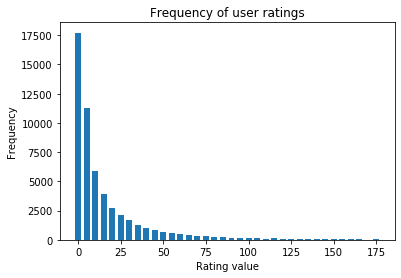

In [8]:
num_of_ratings = ratings_df_init.groupby('user_id').count()['rating']
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180]

plt.hist(num_of_ratings, bins, align="left", rwidth=0.7)
plt.xlabel('Rating value')
plt.ylabel('Frequency')
plt.title('Frequency of user ratings')
plt.show()

We can see above that most users rated between 1 and 25 books, but a few users rated many more (as high as 175 ratings!).

Finally, let's take a look at some of the most highly rated books. This may provide some insight into how our recommendations will be served later on:

In [9]:
books_df_init = pd.read_csv('./data/books.csv')

books_df_init = pd.DataFrame(books_df_init)
top_20_books = pd.DataFrame(ratings_df_init.groupby('book_id').mean().sort_values('rating', ascending=False).head(n=20))

# print(top_20_books)
top20 = []
for bookid in top_20_books.index:
  for x in range(1, len(books_df_init)):
    if books_df_init["id"][x] == bookid:
      top20.append((books_df_init["title"][x]))
    else:
      pass
    
pd.DataFrame(top20, columns = ['Top 20 Highest Rated Books'])

,Top 20 Highest Rated Books
0,ESV Study Bible
1,The Indispensable Calvin and Hobbes
2,The Days Are Just Packed: A Calvin and Hobbes ...
3,Attack of the Deranged Mutant Killer Monster S...
4,The Divan
5,There's Treasure Everywhere: A Calvin and Hobb...
6,"Harry Potter Boxed Set, Books 1-5 (Harry Potte..."
7,The Calvin and Hobbes Lazy Sunday Book
8,The Authoritative Calvin and Hobbes: A Calvin ...
9,It's a Magical World: A Calvin and Hobbes Coll...


As we can see above, there are some popular titles and characters. For instance, **Calvin and Hobbes** books are rated very highly by users in this dataset. Additionally, **Harry Potter**, and a few religous books also round out the top 20. This'll be interesting to note as we start to build our recommender. Based on these initial ratings, we'll likely see some of these show up in our recommendations if a user has not read/rated it before.

### Part 2) Building the Flask application

Given that we'd like to add more data to our initial `goodbook-10k` dataset, I created a very basic python Flask application that allows for the following:  

##### Functionality
+ 1) Allows a user to register/sign-in under a specific username
+ 2) Loads a profile page that displays a history of a user's rated books and provides navigation options to either rate more books or view recommended books  
+ 3) Has a search feature that interacts with the Goodreads API to search for a book by title name. The user can then rate that book on a scale of 1-5. 
+ 4) A user can also find their book recommendations in a separate page 

##### Set-up Process
To set up the application, I first created a basic Flask application, created my routes and page templates, and connected to a local PostgreSQL database. Next, after testing to make sure that I was able to properly register/sign-in each user, obtain specific userids to link back to particular book ratings, I then integrated the Goodreads API into the application to help users search for books that they'd like to rate. By ensuring that any rating that was generated was linked back to the correct bookid and attributed to the correct user, I did a fair bit of testing during this stage. Once the ratings portion of the application was set up, I then deployed my app in **Heroku**, and deployed my local PostgreSQL database to a remote database through the same service. After some testing, I was able to get this functionality working on remote servers. After this, I focused in on creating my recommender engine in PySpark. By using Databrick's built-in interface, this was quite simple. I used ALS (explained below) to serve recommendations to users. I then set up an AWS cluster and deployed the cluster, including the Databricks notebook in order to be able to automate runs on the model every hour. Databricks allows a user to create cron jobs, so I set this setting to re-run the model every hour. By connecting my Databricks notebook to my remote PostgreSQL database through a JDBC connection, I was able to seamlessly work back and forth between my remote database and my Databricks notebook to tweak my model and push new recommendations to my remote database.

Once the model was fine-tuned, I was able to connect the new recommendations table that I created in my remote database to my Flask application and render the information for each recommended book utilizing the same Goodreads API I used earlier. 

##### Challenges building the application
Although I was able to successfully create a process that serves up recommendations every hour for reach user, it would have been much preferred if I could have utilized PySpark outside of a Databricks notebook. This would have made the process a bit easier, and would have streamlined some of the code. I had issues getting PySpark running properly on my local machine, and due to time contraints, couldn't build the engine directly inside my Flask application. Additionally, the Goodreads API was very straightforward to use, but I was a bit limited in the scope of API endpoints that they offered. Because I had to query each individual book to obtain information, you'll notice that navigating between pages such as the 'Profile' page and the 'Recommendations' page is quite slow. Ironically, this is not due to the volume of ratings in my dataset, or the recommender model running in the background, but rather the way I had to retrieve book information from the Goodreads API. These are all items that I hope to adjust in the future, with more time. Finally, I would have really liked to have built out the user interface much more. I have experience working with a few Javascript front-end frameworks (i.e. Angular, etc.), but I ran out of time. Obviously, for this project I was prioritizing getting a working recommender model, and making sure that recommendations were user-specific.

### Part 3) Creating the Recommender Engine and Serving Recommendations Through the Application

##### Creating the ALS model and setting it up to run every hour (based on new user ratings)

Given the setup of the application, I wanted to ensure that new ratings from users were being incorporated into my collaborative filtering technique. I decided to work with PySpark's Alternating Least Squares algorithm for a couple of reasons:  

+ 1) I'm working with a fairly large dataset of book ratings (~1 million), and therefore need to work with an algorithm that can be computationally efficient. ALS and matrix factorization seems to be a good choice once the ALS model is fit to the data.  

+ 2) PySpark provides good documentation for it's ALS function, and has good built-in distributed computing processes to help cut down on processing time.  

+ 3) Since I'm not using any features from my ratings dataset, I'll want to find similarities between users based on books they've rated. Matrix factorization and dimensionality reduction are good techniques to work with for a dataset such as this one. 

In order to do this, I created a JDBC connection to my remote PostgreSQL database, and was able to connect to my ratings table directly. By loading it in as a PySpark dataframe, I could then work with the ~1 million ratings in short order.

##### Importing the data from PostgreSQL

After setting up a remote database in PostgreSQL, and loading in the ratings data, we can now pull it into our Databricks notebook to start our ML work.

First, we need to declare our database credentials and load the JDBC driver that connects between our remote database and Databricks:

In [23]:
import os
driver = os.getenv('DRIVER')
url = os.getenv('URL')
table = os.getenv('TABLE')
user = os.getenv('USER')
password = os.getenv('PASSWORD')
full_url = os.getenv('FULL_URL')

Then, after importing the pyspark sql package contents to build out our schema for our ratings table, we can assign a data type value to each column of our ratings table and save it as `ratings_schema`.

In [25]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

ratings_schema = StructType([
  StructField("col_id", IntegerType()),
  StructField("userid", IntegerType()),
  StructField("rating", DoubleType()),
  StructField("book_id", IntegerType()),
  StructField("username", StringType()),
  StructField("isbn10", StringType())
])

With our schema ready, we can then read in our ratings table from our remote PostgreSQL database, supply the schema we've assigned above, and provide the necessary credentials, also declaried above. We'll save our spark dataframe in a variable called `remote_table`:

In [27]:
remote_table = spark.read.format("jdbc")\
  .option("driver", driver)\
  .option("inferSchema", ratings_schema) \
  .option("url", url)\
  .option("dbtable", table)\
  .option("user", user)\
  .option("password", password)\
  .load()

We can then take a look at the contents of our `remote_table`, which is now saved as a spark data frame.

In [29]:
display(remote_table.select("*")).cache()

col_id,userid,rating,book_id,username,isbn10
1,314,5,1,kaggle,439023483
2,439,3,1,kaggle,439023483
3,588,5,1,kaggle,439023483
4,1169,4,1,kaggle,439023483
5,1185,4,1,kaggle,439023483
6,2077,4,1,kaggle,439023483
7,2487,4,1,kaggle,439023483
8,2900,5,1,kaggle,439023483
9,3662,4,1,kaggle,439023483
10,3922,5,1,kaggle,439023483


This table above is the same table we worked with earlier in our exploration, but given the application that I built in Part 2, we've added a column ID number for each row, a username row, which takes the user information from the application and maps it to a specific book ID and rating, and also the corresponding ISBN number of the book, to help us work within our application later on.  

##### Setting up our ALS model
With our Spark dataframe loaded into Databricks, we then can start to set up our data to run our ALS model. First, we can split the data frame into a training, validation and testing dataset -- 60% training, 20% validation and 20% testing. The validation dataset will be used to test the fine-tuning of our model parameters, and will allow us to have a hold-out test set that we can use to compute the RMSE on our final, optimized model.

In [31]:
(training, validation, test) = remote_table.randomSplit([0.6, 0.2, 0.2])

# caching data to cut down on cross-validation time later
training.cache()
validation.cache()
test.cache()

Out[69]: DataFrame[col_id: int, userid: int, rating: int, book_id: int, username: string, isbn10: string]

After caching the training and test datasets for later, which hopefully will cut down on some processing time, I imported the ALS, evaluation, and tuning functionality from the `pyspark.ml` package. For a base ALS model, we'll set the maximum iterations at 5, our initial regularization parameter at 0.25, and assign our user, book, and rating components to their corresponding column names to set up our matrix. The `ALS()` function conveniently sets up our matrix.

In [33]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

als_dt = ALS(maxIter=5, regParam=0.25, userCol="userid", itemCol="book_id", ratingCol="rating", coldStartStrategy="drop", nonnegative = True, implicitPrefs = False) 

##### Fine-tuning the model parameters

With the base ALS model set, we can then tune our model to ensure we obtain the optimal parameters and rank for our ALS computations. To do this, I borrowed a `tune_ALS()` function from [this article](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1), to help demonstrate this process. Essentially, we will supply a list of parameters and iterate through each to compute the RMSE on our validation dataset. The model with parameters that yield the lowest RMSE will be the one we'll use to run on our final hold-out test dataset:

In [35]:
def tune_ALS(train_data, validation_data, maxIter, regParams, ranks, als_dt):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = als_dt.setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(training)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model

And now we can run the function with our range of parameters:

In [37]:
tune_ALS(training, validation, 10, [.15, .20, .25], [10, 20, 50, 70], als_dt)

10 latent factors and regularization = 0.15: validation RMSE is 0.9251187790506373
10 latent factors and regularization = 0.2: validation RMSE is 0.911303798674784
10 latent factors and regularization = 0.25: validation RMSE is 0.9102230973739172
20 latent factors and regularization = 0.15: validation RMSE is 0.9180876886516705
20 latent factors and regularization = 0.2: validation RMSE is 0.9093585736908846
20 latent factors and regularization = 0.25: validation RMSE is 0.909896159236216
50 latent factors and regularization = 0.15: validation RMSE is 0.9074113507297799
50 latent factors and regularization = 0.2: validation RMSE is 0.9057946226241741
50 latent factors and regularization = 0.25: validation RMSE is 0.9086605001930027
70 latent factors and regularization = 0.15: validation RMSE is 0.9062863932865718
70 latent factors and regularization = 0.2: validation RMSE is 0.905996191081747
70 latent factors and regularization = 0.25: validation RMSE is 0.9091846850715163

The best model has 50 latent factors and regularization = 0.2
Out[72]: ALS_c000b77f7b07

As we can see above from the outputs, the best model (for this specific run), will contain 50 latent factors (rank 50), and a regularization parameter value of 0.2.

##### Fitting the model to our training dataset

We can then run our ALS model with these optimal parameters, and fit this to our training dataset.

In [40]:
als = ALS(maxIter=10, regParam=0.20, userCol="userid", itemCol="book_id", ratingCol="rating", coldStartStrategy="drop", nonnegative = True, implicitPrefs = False).setRank(50)

In [41]:
model = als.fit(training)

We can then use this model to compute predictions on our test dataset and compute the RMSE value.

In [43]:
predictions = model.transform(test)

In [44]:
rmse = evaluator.evaluate(predictions)

In [45]:
# Evaluation results
print("RMSE : {}".format(str(rmse)))

RMSE : 0.9069674858525751

##### Generating book recommendations for all users

As we can see above, our RMSE value is around 0.9, which for our purposes, and a likert scale of 1-5, it isn't too bad. We can use this model to generate predictions and recommendations. To do this, we can use the `recommendForAllUsers()` function in PySpark, to attempt to find the 10 highest rated books for each user.

In [47]:
# Generate n recommendations for all users
ALS_recommendations = model.recommendForAllUsers(numItems = 10)

As an example, I've printed out the book recommendations for one user in our dataset (this is the first user I created in my application!). Interestingly, we can see that due to the types of books that this user rated initially, the recommendations are all books outside the scope of the 10,000 books in our initial Goodreads dataset (all book_id's below are above 10,000). This is to be expected given that all of the books that this user rated were "Data Science" books, which aren't part of the `books.csv` dataset. Fortunately for us, other custom users (that are data science fanatics) have also rated these books, and others similar to these, which shows that the recommendations and algorithm are working quite nicely.

In [49]:
display(ALS_recommendations.filter(ALS_recommendations['userid'] == 53427))

userid,recommendations
53427,"List(List(10025, 4.7729807), List(10026, 4.7729807), List(10024, 4.7729807), List(10027, 4.7729807), List(10029, 4.7729807), List(10028, 4.6535206), List(10020, 4.4985204), List(10036, 4.4262066), List(10034, 4.4262066), List(10001, 3.8394945))"


Now, we can manipulate the recommendations above and orient them in a tabular format. To do this, we'll use `spark.sql`:

In [51]:
# Temporary table
ALS_recommendations.registerTempTable("ALS_recs_temp")
clean_recs = spark.sql("""SELECT userid,
                            bookIds_and_ratings.book_id AS book_id,
                            bookIds_and_ratings.rating AS prediction
                        FROM ALS_recs_temp LATERAL VIEW explode(recommendations) exploded_table AS bookIds_and_ratings""")

Additionally, we can pull back in some of the columns from our initial `remote_table` before we continue processing:

In [53]:
clean_recs.join(remote_table, ["userid", "book_id"], "left").filter(remote_table.rating.isNull()).show()

clean_recs_filtered = clean_recs.select("userid", "book_id", "prediction")

display(clean_recs_filtered)

userid,book_id,prediction
148,5207,4.62019
148,10020,4.6170945
148,6920,4.5810843
148,6590,4.555902
148,9566,4.5549664
148,3628,4.532255
148,7254,4.51552
148,6862,4.5137057
148,9076,4.50106
148,6361,4.4931087


Now, with our 10 recommendations ready, we need to make sure that the recommended books in each user's list haven't already been rated (and implicitly been read by the user). We can filter out any recommendations that have been rated by that user:

In [55]:
new_books = (clean_recs_filtered.join(remote_table, ["userid", "book_id"], "left").filter(remote_table.rating.isNull()))

In the end, we can save just the new book recommendations to eventually push back to our remote PostgreSQL table:

In [57]:
new_books_fnl = new_books.select('userid', 'book_id', 'prediction')

new_books_users = new_books_fnl.filter(new_books_fnl['userid'] > 53424)

new_books_use = new_books_users.select('userid', 'book_id', 'prediction')

display(new_books_use)

userid,book_id,prediction
53429,10026,3.7028527
53427,10034,4.4262066
53426,6590,5.2477336
53426,5580,5.1231766
53426,6361,5.1833167
53428,5580,4.003819
53427,10036,4.4262066
53428,6361,4.0357094
53426,6920,5.243292
53428,10036,4.064948


And finally, using our "write" command, we can overwrite the existing table in our remote table with our new recommendations:

In [59]:
new_books_use.write.option("truncate", "true").jdbc(url=full_url, table='new_recs', mode='overwrite')

### Conclusion

##### Overall performance
After running the model multiple times, I've been happy to see that it is serving up recommendations that fit past user ratings quite well. For instance, many of the books that I rated as an initial user (most books were Data Science Books), were being recommended to other users that I've created that have rated some of the same Data Science books. I was also noticing that books rated by the other users with some overlapping Data Science book ratings, were being recommended to my initial user. This demonstrates that the ALS calculations are working effectively, and the recommender system is functioning as expected. Given that the overall approach was to use collaborative filtering to serve up recommendations, I feel like it's been effectively living up to this task. 

##### Caveats (so many Calvin and Hobbes recommendations!)
However, there are a few caveats to this recommender model. One, I noticed that a lot of recommendations are being made based on the most highly rated books (especially when the prediction calculations are low for a particular user). Therefore, when looking at the highest rated books in the `goodbooks-10k` dataset, we notice that many *Calvin and Hobbes* books are at the top of the list. The recommender is definitely recommending these books to many users, especially when it isn't able to find users that match similarity quite well. For instance, one of my custom users rated many books outside of the initial list of 10,000 books in the dataset, and no other users had also rated these books, which meant that when ALS ran its calculations, the predictions were not too great. If more users were to rate books on the application, my hope is that this would even out. However, many users will be seeing *Calvin and Hobbes* books flood their recommendation lists for quite some time!  

##### Takeaways
In the end, I was able to create a full production application that serves up user-specific book recommendations based on user ratings of past books. This project was a great way to bring some of the content that we learned this semester into a comprehensive system. Hopefully in the future, I can continue to fine-tune the ALS model, and add in a few more algorithms/approaches to make the recommender system even more effective. One idea is to set up a hybrid model that also factors in content-based filtering. Since the `goodbooks-10k` dataset has book categories tagged for each book, it would be a great way to add in an additional set of features/parameters to make the model serve recommendations that are more specific. For instance, although *Calvin and Hobbes* may be a very highly rated set of books, if a user rated a list of drama books quite highly, my hope would be that the content-based filtering would be able to serve up highly rated drama books instead of *Calvin and Hobbes* books (which fall outside of this category).

##### Create an account and interact with the recommender
Hopefully this has been an interesting project to read through. If interested, please do create an account on the application and start rating some books! Hopefully you'll start to see recommendations that match your tastes!

+ **Application Website:** https://zach-book-recommender.herokuapp.com/  
+ **Explainer Video** https://www.youtube.com/watch?v=Z5JhqceWrzc&feature=youtu.be (the video cuts off at the end due to a 15-minute time limit, but I pretty much covered everything in the allotted time.)

For any questions, feel free to reach out at zachary.alexander33@spsmail.cuny.edu